# 1. Packages

In [1]:
'''
numpy - scientific computing with Python
matplotlib - plot graphs in Python
h5py - interact with a dataset that is stored on an H5 file
'''
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
import h5py

# sklearn provides simple and efficient tools for data mining and data analysis.
import sklearn
import sklearn.datasets
import sklearn.linear_model

%matplotlib inline

%load_ext autoreload
%autoreload 2

# 2. Data Loading and Preprocess

y = [0], it's a 'non-cat' picture.


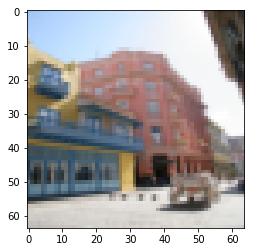

In [2]:
# Load dataset
def load_data():
    train_dataset = h5py.File('datasets/train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('datasets/test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

# Loading the data (cat/non-cat)
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_data()

# Example of a picture
index = 23
plt.imshow(train_set_x_orig[index])
print("y = " + str(train_set_y[:, index]) + ", it's a '" + classes[np.squeeze(train_set_y[:, index])].decode("utf-8") + "' picture.")

In [3]:
# Print the sizes of data
print("train_set_x_orig shape: " + str(train_set_x_orig.shape))
print("train_set_y shape: " + str(train_set_y.shape))
print("test_set_x_orig shape: " + str(test_set_x_orig.shape))
print("test_set_y shape: " + str(test_set_y.shape))
print("classes shape: " + str(classes.shape))

train_set_x_orig shape: (209, 64, 64, 3)
train_set_y shape: (1, 209)
test_set_x_orig shape: (50, 64, 64, 3)
test_set_y shape: (1, 50)
classes shape: (2,)


In [4]:
# Reshape the training and test examples
train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T

print("train_set_x_flatten shape: " + str(train_set_x_flatten.shape))
print("test_set_x_flatten shape: " + str(test_set_x_flatten.shape))

train_set_x_flatten shape: (12288, 209)
test_set_x_flatten shape: (12288, 50)


In [5]:
# Standardize the dataset
train_set_x = train_set_x_flatten/255.
test_set_x = test_set_x_flatten/255.

# 3. Building Deep Neural Network

## 3.1 Initialization

In [6]:
def initialize_parameters(layer_dims):
    """
    Arguments:
    layer_dims -- python list containing the dimensions of each layer
    
    Returns:
    parameters -- python dictionary containing parameters 'W1', 'b1', ..., 'WL', 'bL'
                    Wl -- weight matrix of shape (layer_dims[l], layer_dims[l-1])
                    bl -- bias vector of shape (layer_dims[l], 1)
    """
    
    parameters = {}
    L = len(layer_dims) # number of layers, including input layer
    
    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) / np.sqrt(layer_dims[l-1])
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
        
        assert(parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l-1]))
        assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))
        
    return parameters

## 3.2 Forward Propagation

In [7]:
def linear_activation_forward(A_prev, W, b, activation):
    """
    Forward propagation of one layer, including linear and activation.
    
    Arguments:
    A_prev -- activations of previous layer (or dataset) of shape (size of previous layer, number of examples)
    W -- weights matrix of shape (size of current layer, size of previous layer)
    b -- bias vector of shape (size of current layer, 1)
    activation -- text string, "sigmoid" or "relu"
    
    Returns:
    A -- activation values of shape (size of current layer, number of examples)
    cache -- tuple containing A_prev, Z, W and b
    """
    
    Z = np.dot(W, A_prev) + b
    
    if activation == "sigmoid":
        A = 1 / (1 + np.exp(-Z))
    
    elif activation == "relu":
        A = np.maximum(0, Z)
        
    assert(Z.shape == (W.shape[0], A.shape[1]))
    assert (A.shape == (W.shape[0], A_prev.shape[1]))
    cache = (A_prev, Z, W, b)

    return A, cache


def forward_propagation(X, parameters):
    """
    Total forward propagation including [LINEAR -> RELU]*(L-1) -> [LINEAR -> SIGMOID].
    
    Arguments:
    X -- the input dataset of size (size of input layer, number of examples)
    parameters -- dictionary containing Wl and bl
    
    Returns:
    AL -- last post-activation value of shape (size of output layer, number of examples)
    caches -- list of all cache of each layer, indexed from 0 to L-1, total length of L
    """
    
    caches = []
    A = X
    L = len(parameters) // 2
    
    # Implement [LINEAR -> RELU]*(L-1)
    for l in range(1, L):
        A_prev = A
        A, cache = linear_activation_forward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], "relu")
        caches.append(cache)
    
    # Implement [LINEAR -> SIGMOID]
    AL, cache = linear_activation_forward(A, parameters['W' + str(L)], parameters['b' + str(L)], "sigmoid")
    caches.append(cache)
    
    assert(AL.shape == (1, X.shape[1]))
    
    return AL, caches

## 3.3 Cost Function

In [8]:
def compute_cost(AL, Y):
    """
    Arguments:
    AL -- last post-activation value of shape (1, number of examples)
    Y -- true 'label' vector of shape (1, number of examples)
    
    Returns:
    cost -- cross-entropy cost
    """
    
    m = Y.shape[1]
    cost = -1/m * (np.dot(Y, np.log(AL.T)) + np.dot(1 - Y, np.log(1 - AL.T)))
    
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    
    return cost

## 3.4 Backward Propagation

In [9]:
def linear_activation_backward(dA, cache, activation):
    """
    Backward propagation of one layer.
    
    Arguments:
    dA -- post-activation gradient for current layer, shape (size of current layer, number of examples)
    cache -- tuple containing A_prev, Z, W and b
    activation -- "sigmoid" or "relu"
    
    Returns:
    dA_prev -- post-activation gradient for previous layer, shape (size of previous layer, number of examples)
    dW -- weights gradients of shape (size of current layer, size of previous layer)
    db -- bias gradient of shape (size of current layer, 1)
    """

    A_prev, Z, W, b = cache # unpack cache to A_prev, Z, W, b
    m = dA.shape[1]
    
    # Calculate dZ
    if activation == "sigmoid":
        s = 1/(1+np.exp(-Z))
        dZ = dA * s * (1-s)
    
    elif activation == "relu":
        dZ = np.array(dA, copy=True)
        dZ[Z <= 0] = 0
    
    # Calculate dW, db and dA_prev
    dW = 1/m * np.dot(dZ, A_prev.T)
    db = 1/m * np.sum(dZ, axis=1, keepdims=1)
    dA_prev = np.dot(W.T, dZ)
    
    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)
    
    return dA_prev, dW, db
    

def backward_propagation(AL, Y, caches):
    """
    Arguments:
    AL -- last post-activation value of shape (1, number of examples)
    Y -- true 'label' vector of shape (1, number of examples)
    caches -- list of all cache of every layer
    
    Returns:
    grads -- dictionary containing dA, dW, db of all layers
    """
    
    grads = {}
    L = len(caches)
    m = AL.shape[1]
    
    # Calculate dAL
    grads["dA" + str(L)] = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    
    # Output layer
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(grads["dA" + str(L)], caches[L-1], "sigmoid")
    
    # Other layers, from l = L-2 to 0
    for l in reversed(range(L-1)):
        grads["dA" + str(l)], grads["dW" + str(l+1)], grads["db" + str(l+1)] = linear_activation_backward(grads["dA" + str(l+1)], caches[l], "relu")
    
    return grads

## 3.5 Update Parameters

In [10]:
def update_parameters(parameters, grads, learning_rate):
    """
    Arguments:
    parameters -- dictionary of original W and b of all layers
    grads -- dictionary of dA, dW and db of all layers
    learning_rate -- scalar
    
    Returns:
    parameters -- dictionary of updated W and b of all layers
    """
    
    L = len(parameters) // 2
    for l in range(1, L+1):
        parameters['W' + str(l)] = parameters['W' + str(l)] - learning_rate * grads['dW' + str(l)]
        parameters['b' + str(l)] = parameters['b' + str(l)] - learning_rate * grads['db' + str(l)]
        
    return parameters

## 3.6 Prediction

In [11]:
def predict(X, y, parameters):
    """
    This function is used to predict the results of a  L-layer neural network.
    
    Arguments:
    X -- data set of examples you would like to label
    y -- true "label" vector
    parameters -- parameters of the trained model
    
    Returns:
    p -- predictions for the given dataset X
    """
    
    m = X.shape[1]
    n = len(parameters) // 2 # number of layers in the neural network
    p = np.zeros((1,m))
    
    # Forward propagation
    probas, caches = forward_propagation(X, parameters)

    # convert probas to 0/1 predictions
    for i in range(0, probas.shape[1]):
        if probas[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0
    
    # Print results
#     print ("predictions: " + str(p))
#     print ("true labels: " + str(y))
#     print("Accuracy: "  + str(np.sum((p == y)/m)))
        
    return p

# 4. Set up DNN for the Classifier
Merge all the helper functions above to a model.

In [12]:
def DNN_model(X, Y, test_X, test_Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost = False):
    """
    Combine all the steps into one model.
    
    Arguments:
    X -- data of shape (num_px * num_px * num_px, number of examples)
    Y -- true "label" vector of shape (1, number of examples)
    layers_dims -- list containing the dimensions of all layers, including input layer
    learning_rate -- learning rate of the gradient descent
    num_iterations -- number of iterations of optimization loops
    print_cost -- if True, prints the cost every 100 steps
    
    Returns:
    parameters -- parameters learnt by the model, which can be used for prediction
    """
    
    # Keep track of costs and predictions
    costs = []
    preds_train = []
    preds_test = []
    
    m_train = X.shape[1]
    m_test = test_X.shape[1]
    
    # Initialize parameters
    parameters = initialize_parameters(layers_dims)
    
    # Gradient descent loop
    for i in range(num_iterations):
        # Forward propagation
        AL, caches = forward_propagation(X, parameters)
        
        # Compute cost
        cost = compute_cost(AL, Y)
        
        # Backward propagation
        grads = backward_propagation(AL, Y, caches)
        
        # Update parameters
        parameters = update_parameters(parameters, grads, learning_rate)
        
        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
            costs.append(cost)
            
            pred_train = predict(X, Y, parameters)
            preds_train.append(np.sum((pred_train == Y)/m_train))
            print("Accuracy of train set: "  + str(np.sum((pred_train == Y)/m_train)))
            
            pred_test = predict(test_X, test_Y, parameters)
            preds_test.append(np.sum((pred_test == test_Y)/m_test))
            print("Accuracy of test set: "  + str(np.sum((pred_test == test_Y)/m_test)))
            print('\n')
    
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Cost")
    plt.show()
    
    # plot the prediction of train
    plt.plot(np.squeeze(preds_train))
    plt.ylabel('predictions accuracy of training set')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Prediction Accuracy of Training Set")
    plt.show()
    
    # plot the prediction of test
    plt.plot(np.squeeze(preds_test))
    plt.ylabel('predictions accuracy of test set')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Prediction Accuracy of Test Set")
    plt.show()
    
    return parameters

# 5. Training

Cost after iteration 0: 0.691780
Accuracy of train set: 0.6028708133971292
Accuracy of test set: 0.36


Cost after iteration 100: 0.617515
Accuracy of train set: 0.6602870813397128
Accuracy of test set: 0.3400000000000001


Cost after iteration 200: 0.541338
Accuracy of train set: 0.7607655502392343
Accuracy of test set: 0.4600000000000001


Cost after iteration 300: 0.513013
Accuracy of train set: 0.8755980861244017
Accuracy of test set: 0.7200000000000001


Cost after iteration 400: 0.483223
Accuracy of train set: 0.8564593301435405
Accuracy of test set: 0.78


Cost after iteration 500: 0.445304
Accuracy of train set: 0.8708133971291865
Accuracy of test set: 0.8


Cost after iteration 600: 0.415484
Accuracy of train set: 0.8708133971291865
Accuracy of test set: 0.8


Cost after iteration 700: 0.379265
Accuracy of train set: 0.8708133971291865
Accuracy of test set: 0.8


Cost after iteration 800: 0.318354
Accuracy of train set: 0.8995215311004783
Accuracy of test set: 0.8


Cost after

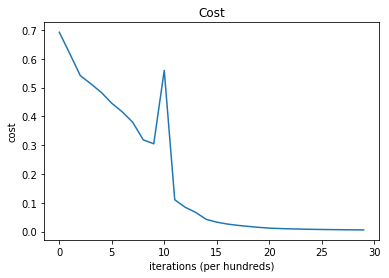

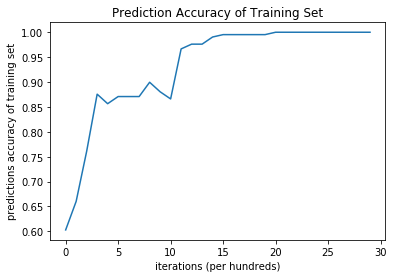

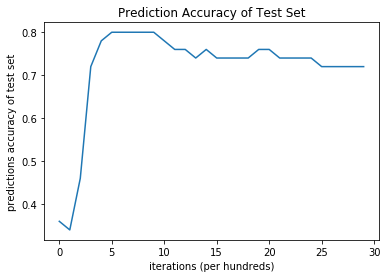

In [13]:
# DNN dimensions
layers_dims = [12288, 20, 7, 5, 1] # 4-layer model

parameters = DNN_model(train_set_x, train_set_y, test_set_x, test_set_y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost = True)